# Backtes the three PTS Methods

In [1]:
from Helpers.TstMethods import *
from Helpers.FunctHelpers import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Donwnload data
tickers = pd.read_excel('Data/SandP500list.xlsx')
tickers = tickers[tickers['sector'] == 'Financials']
names = tickers['symbol'].tolist()

START_DATE = pd.to_datetime('2022-01-01') # 2022
END_DATE = pd.to_datetime('2024-07-01')

data = download_data(names, START_DATE, END_DATE)

[*********************100%***********************]  65 of 65 completed


5 Failed downloads:
['RE', 'BRK.B', 'PBCT', 'WLTW', 'FRC']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [3]:
# Performe rolling backtest of the Three PTS Methods

# Define the number of testing periods
num_testing_peiods = pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)
start_date, end_date = START_DATE, START_DATE + pd.DateOffset(months=18)

# define lists to store the signals and returns
dm_backtest_signals = []
dm_backtest_returns = []

coint_backtest_signals = []
coint_backtest_returns = []

copula_backtest_signals =[]
copula_backtest_returns = []

for i in range(num_testing_peiods.days):

    # Split data into training and testing
    train_start, train_end, test_start, test_end = train_test_dates(start_date)
    train_data, test_data = train_test_split(data, train_start, train_end, test_start, test_end)

    # Get Signals
    dm_signals, dm_pairs = dm_get_signals_pairs(train_data, test_data)
    dm_backtest_signals.append(dm_signals)

    coint_signals, coint_pairs = coint_get_signals_pairs(train_data, test_data) #! Changes test df
    coint_backtest_signals.append(coint_signals)

    # copula_signals = copula_get_signals(train_data, test_data) # Copula signals are not implemented yet
    # copula_backtest_signals.append(copula_signals)

    # Calculate Returns
    dm_daily_returns_pct = calculate_returns(dm_signals, dm_pairs, test_data)
    dm_backtest_returns.append(dm_daily_returns_pct)

    coint_daily_returns_pct = calculate_returns(coint_signals, coint_pairs, test_data)
    coint_backtest_returns.append(coint_daily_returns_pct)

    # copula_daily_returns_pct = calculate_returns(copula_signals, copula_pairs, test_data)
    # copula_backtest_returns.append(copula_daily_returns_pct)

    # Update Dates, Print Info and beak
    print_backtest_info(i, start_date, end_date)
    start_date, end_date = update_dates(start_date)
    if (pd.to_datetime(end_date)) == pd.to_datetime(END_DATE):
        break

Backtest Period: 1
Start Date: 2022-01-01 End Date: 2023-07-01
-------------------------------------------
Backtest Period: 2
Start Date: 2022-02-01 End Date: 2023-08-01
-------------------------------------------
Backtest Period: 3
Start Date: 2022-03-01 End Date: 2023-09-01
-------------------------------------------
Backtest Period: 4
Start Date: 2022-04-01 End Date: 2023-10-01
-------------------------------------------
Backtest Period: 5
Start Date: 2022-05-01 End Date: 2023-11-01
-------------------------------------------
Backtest Period: 6
Start Date: 2022-06-01 End Date: 2023-12-01
-------------------------------------------
Backtest Period: 7
Start Date: 2022-07-01 End Date: 2024-01-01
-------------------------------------------
Backtest Period: 8
Start Date: 2022-08-01 End Date: 2024-02-01
-------------------------------------------
Backtest Period: 9
Start Date: 2022-09-01 End Date: 2024-03-01
-------------------------------------------
Backtest Period: 10
Start Date: 2022-

In [4]:
# Example usage of the backtesting results

# each column represents the returns of a single testing period (12 mothn calubration and 6 month testing period)
# col is a touple containing the returns of the testing period as a df

for col in dm_backtest_returns:
    
    # Get start and end date of the testing period
    start_date, end_date = col[0].index[0], col[0].index[-1]
    start_date = start_date.strftime('%Y-%m')
    end_date = end_date.strftime('%Y-%m')

    # Cumulative return of a portfolio that is equally weighted for all the pairs
    cum_return = col[0].sum().sum()
    #cum_return = col[0].cumsum().iloc[-1].sum() # also works

    print(f'Cumulative returns for the testing period, from: {start_date} to: {end_date}')
    print(f'Cumulative return: {cum_return:.2f}%')
    print('-'*69)

Cumulative returns for the testing period, from: 2023-01 to: 2023-06
Cumulative return: -3.94%
---------------------------------------------------------------------
Cumulative returns for the testing period, from: 2023-02 to: 2023-08
Cumulative return: -4.16%
---------------------------------------------------------------------
Cumulative returns for the testing period, from: 2023-03 to: 2023-09
Cumulative return: -4.69%
---------------------------------------------------------------------
Cumulative returns for the testing period, from: 2023-04 to: 2023-09
Cumulative return: 1.23%
---------------------------------------------------------------------
Cumulative returns for the testing period, from: 2023-05 to: 2023-11
Cumulative return: 0.72%
---------------------------------------------------------------------
Cumulative returns for the testing period, from: 2023-06 to: 2023-12
Cumulative return: -0.40%
---------------------------------------------------------------------
Cumulative r

In [5]:
import pandas as pd

def calculate_cumulative_returns(backtest_returns):
    # Flatten the tuple structure if nested and ensure we extract only DataFrames
    def flatten(items):
        for x in items:
            if isinstance(x, (pd.DataFrame, pd.Series)):
                yield x
            elif isinstance(x, (list, tuple, set)):
                yield from flatten(x)
    
    # Flatten and filter for DataFrames
    dfs = list(flatten(backtest_returns))
    
    if not dfs:
        raise ValueError("No DataFrame objects found in the provided input.")
    
    # Concatenate the DataFrames
    combined_df = pd.concat(dfs, axis=0)
    
    # Average the returns for overlapping dates
    averaged_returns = combined_df.groupby(combined_df.index).mean()
    
    # Calculate cumulative returns from averaged daily returns
    cum_returns = [1]
    for return_value in averaged_returns['portfolio']:
        cum_returns.append(cum_returns[-1] * (1 + return_value / 100))
    
    return cum_returns


dm_cumulative_returns = calculate_cumulative_returns(dm_backtest_returns)
coint_cumulative_returns = calculate_cumulative_returns(coint_backtest_returns)
# copula_cumulative_returns = calculate_cumulative_returns(copula_backtest_returns)

print(dm_cumulative_returns)


[1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9956735325437953, 0.9736509816594936, 0.9629219313920223, 0.9517712280716786, 0.9382552583211002, 0.9313704356115265, 0.92195038538757, 0.9121495070383586, 0.9026883393072647, 0.8976129648433173, 0.8924579833302022, 0.8884816450338199, 0.8834064539093106, 0.8785847613352356, 0.8738309755588045, 0.8692955482620628, 0.8646878425103334, 0.859800198488537, 0.8551714374219243, 0.8505278430750761, 0.8461437676341554, 0.8416657418696011, 0.837510821241243, 0.833256195002704, 0.8290702336347445, 0.8256816118705518, 0.8219050727848515, 0.8181458070007008, 0.815651092675373, 0.811967523992957, 0.8088774440364276, 0.8056371593934704, 0.8022150354642376, 0.7990812613968882, 0.7959927944559648, 0.7918918193801634, 0.7945011612653377, 0.7794951030528685, 0.769718144978622, 0.7575085900093557, 0.747476003165724, 0.7361015836117616, 0.7263070937584514, 0.7171352314878605, 0.7077378991805906, 0.6977737324809477, 0.6899482762604635, 0.68018800

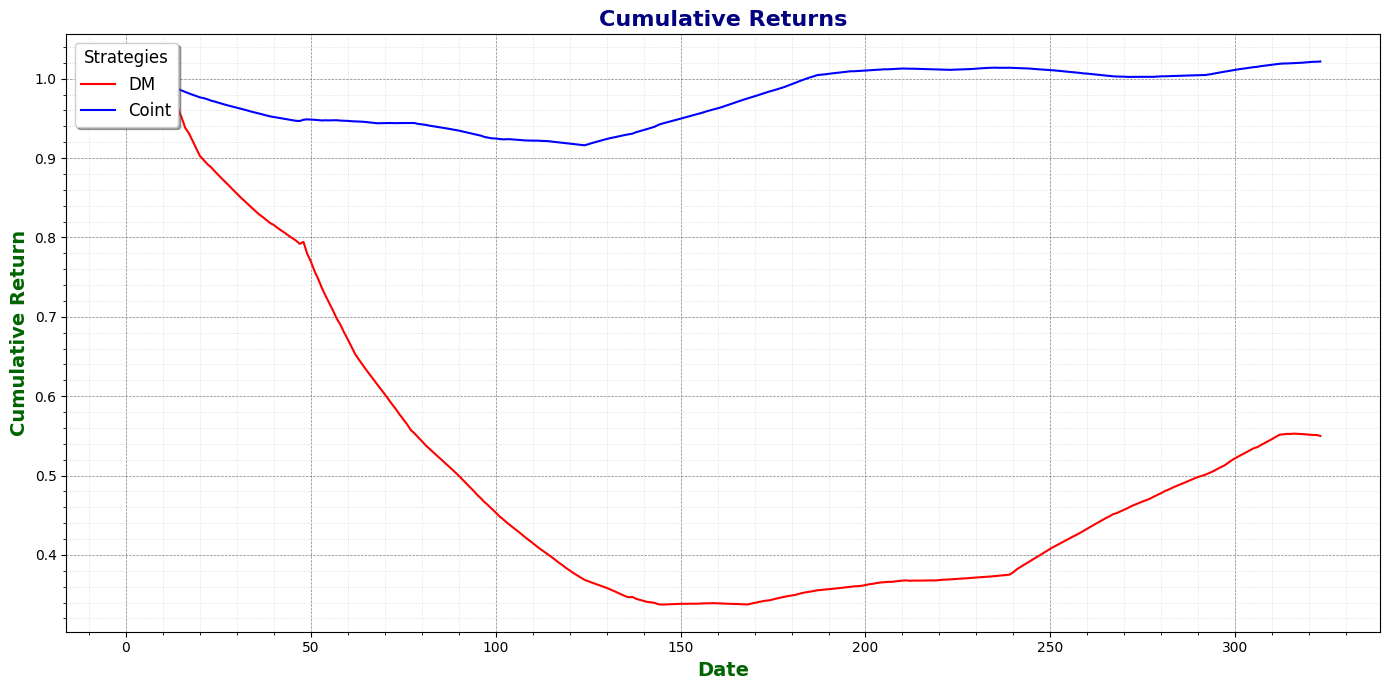

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_cumulative_returns(dm_cumulative_returns, coint_cumulative_returns, copula_cumulative_returns=None):
    """
    Calculate and plot average and cumulative returns for trading strategies.

    Args:
        dm_cumulative_returns (list): Cumulative returns for the DM strategy.
        coint_cumulative_returns (list): Cumulative returns for the Cointegration strategy.
        copula_cumulative_returns (optional, list): Cumulative returns for the Copula strategy.

    Returns:
        None. Displays two plots for average and cumulative returns.
    """
    # Create a DataFrame for the cumulative returns
    cumulative_returns = pd.DataFrame({
        'DM': dm_cumulative_returns,
        'Coint': coint_cumulative_returns
    })

    # If copula returns are provided, add them to the DataFrame
    if copula_cumulative_returns is not None:
        cumulative_returns['Copula'] = copula_cumulative_returns

    # Plot cumulative returns
    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_returns.index, cumulative_returns['DM'], label='DM', color='red')
    plt.plot(cumulative_returns.index, cumulative_returns['Coint'], label='Coint', color='blue')
    if 'Copula' in cumulative_returns:
        plt.plot(cumulative_returns.index, cumulative_returns['Copula'], label='Copula', color='green')

    plt.title('Cumulative Returns', fontsize=16, fontweight='bold', color='navy')
    plt.xlabel('Date', fontsize=14, fontweight='bold', color='darkgreen')
    plt.ylabel('Cumulative Return', fontsize=14, fontweight='bold', color='darkgreen')
    plt.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgrey')
    plt.legend(shadow=True, fancybox=True, title='Strategies', title_fontsize='12', fontsize='12', loc='upper left')
    plt.tight_layout()
    plt.show()

# Usage example (assuming `dm_cumulative_returns`, `coint_cumulative_returns`, and `copula_cumulative_returns` are available)
plot_cumulative_returns(dm_cumulative_returns, coint_cumulative_returns, copula_cumulative_returns=None)


In [7]:
def get_strategy_daily_returns(backtest_returns):
    """
    Extracts daily returns from the backtesting results of a strategy.

    Args:
        backtest_returns (dataframe): A dataframe containing the backtesting results of a strategy,
        each column are the returns of of one pair within the startegy.

    Returns:
        list: A list of daily returns for the strategy.
    """
        # Initialize lists for daily returns
    daily_returns = []

    # Collect daily returns for each strategy
    for col in backtest_returns:
        for day in col[0].columns:
            daily_return = col[0][day].sum()
            daily_returns.append(daily_return)

    return daily_returns


dm_daily_returns = get_strategy_daily_returns(dm_backtest_returns)
coint_daily_returns = get_strategy_daily_returns(coint_backtest_returns)
#copula_daily_returns = get_strategy_daily_returns(copula_backtest_returns)

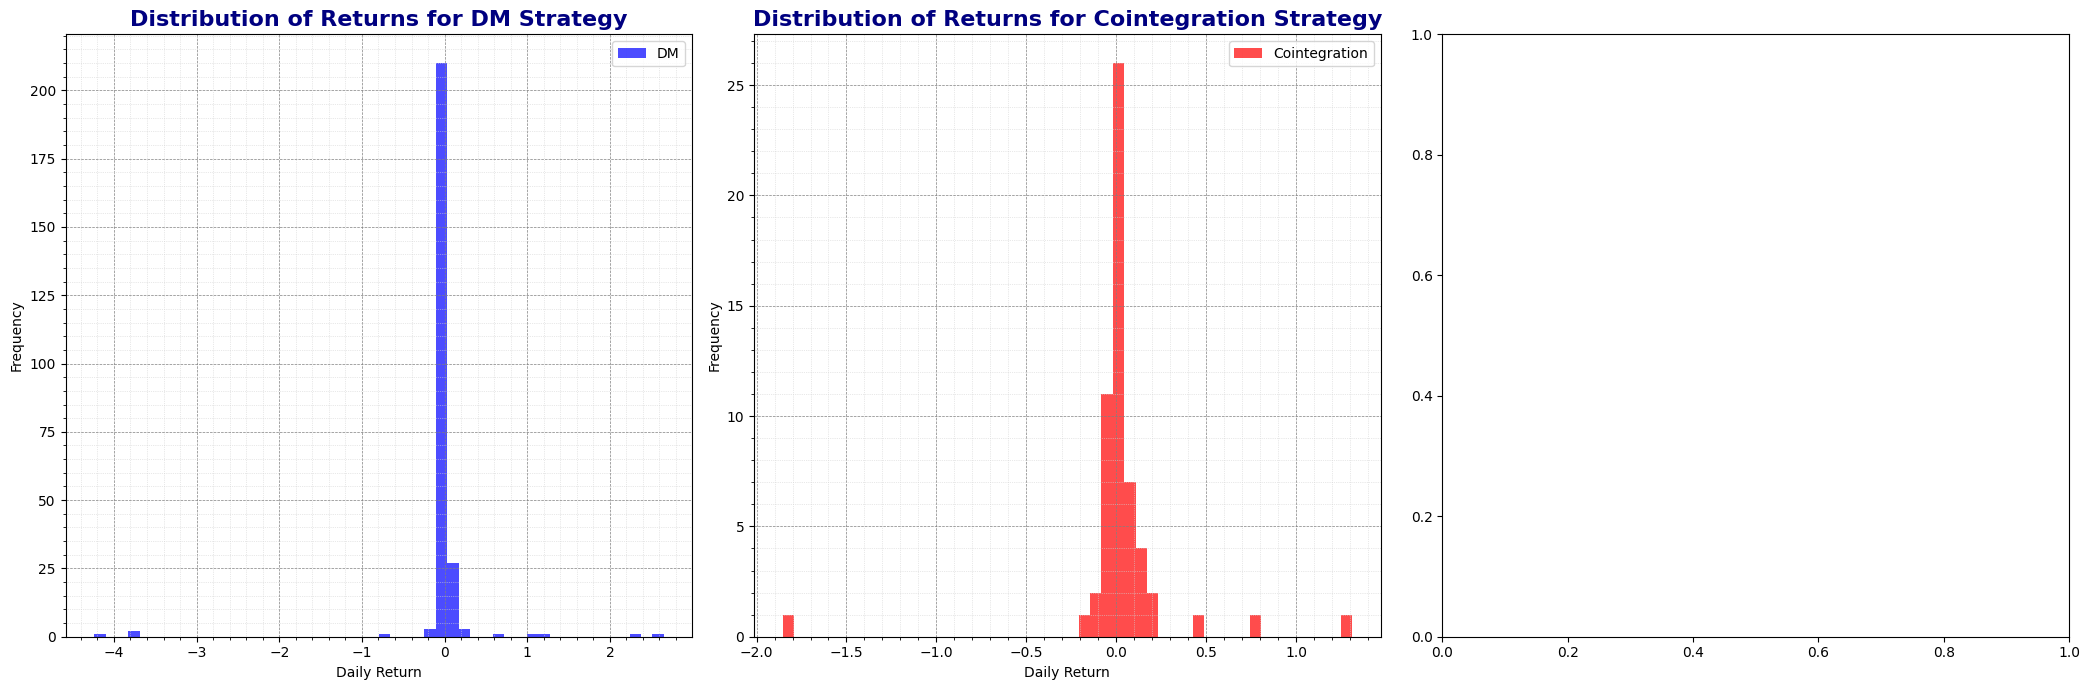

In [8]:
def plot_strategy_returns(dm_daily_returns, coint_daily_returns, copula_daily_returns):
    """
    Plots histograms of the distribution of daily returns for three investment strategies: DM, Cointegration, and Copula.

    Args:
        dm_backtest_returns (list): A list containing the daily returns data for the DM strategy.
        coint_backtest_returns (list): A list containing the daily returns data for the Cointegration strategy.
        copula_backtest_returns (list): A list containing the daily returns data for the Copula strategy.
    """


    # Plot histograms in a subplot layout
    fig, ax = plt.subplots(1, 3, figsize=(21, 7))  # Adjusted to accommodate three subplots

    # Data for plotting
    returns_data = [dm_daily_returns, coint_daily_returns, copula_daily_returns]
    if copula_daily_returns is None:
        strategies = ['DM', 'Cointegration']
        colors = ['blue', 'red']  # Different colors for each strategy
    else:
        strategies = ['DM', 'Cointegration', 'Copula']
        colors = ['blue', 'red', 'green']  # Different colors for each strategy

    # Create histogram for each strategy
    for index, strategy in enumerate(strategies):
        ax[index].hist(returns_data[index], bins=50, color=colors[index], alpha=0.7, label=strategy)
        ax[index].set_title(f'Distribution of Returns for {strategy} Strategy', fontsize=16, fontweight='bold', color='navy')
        ax[index].set_xlabel('Daily Return')
        ax[index].set_ylabel('Frequency')
        ax[index].grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')
        ax[index].minorticks_on()
        ax[index].grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgrey')
        ax[index].legend()

    # Improve layout
    plt.tight_layout()
    plt.show()

# Example usage:
plot_strategy_returns(dm_daily_returns, coint_daily_returns, copula_daily_returns=None)
